# 2D

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

np.random.seed(1234)  # Установка семени для генератора случайных чисел NumPy
tf.random.set_seed(1234)  # Установка семени для генератора случайных чисел TensorFlow

In [2]:
class PhysicsInformedNN:
    def __init__(self, x, y, t, u, v, layers):
        # Объединяем входные данные x, y и t в одном массиве
        X = np.concatenate([x, y, t], 1)

        # Установка нижних и верхних границ области на основе входных данных
        self.lb = X.min(0)  # Нижняя граница
        self.ub = X.max(0)  # Верхняя граница

        self.X = X  # Сохраняем объединенные входные данные

        self.x = X[:,0:1]  # Извлекаем координату x
        self.y = X[:,1:2]  # Извлекаем координату y
        self.t = X[:,2:3]  # Извлекаем временную координату t

        self.u = u  # Сохраняем значение u (например, скорость)
        self.v = v  # Сохраняем значение v (например, скорость)

        # Определяем структуру нейронной сети
        self.layers = layers

        # Инициализируем веса и смещения
        self.weights, self.biases = self.initialize_NN(layers)

        # Инициализация параметров для физических уравнений
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)  # Переменная lambda_1
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)  # Переменная lambda_2

        # Преобразование входных данных в тензоры для TensorFlow
        self.x_tf = tf.convert_to_tensor(np.reshape(x, (-1, 1)), dtype=tf.float32)
        self.y_tf = tf.convert_to_tensor(np.reshape(y, (-1, 1)), dtype=tf.float32)
        self.t_tf = tf.convert_to_tensor(np.reshape(t, (-1, 1)), dtype=tf.float32)  # Временные границы

        self.u_tf = tf.convert_to_tensor(np.reshape(u, (-1, 1)), dtype=tf.float32)  # Преобразуем u в тензор
        self.v_tf = tf.convert_to_tensor(np.reshape(v, (-1, 1)), dtype=tf.float32)  # Преобразуем v в тензор

        # Получаем начальные предсказания с помощью нейронной сети
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)

        # Определяем оптимизатор Adam для обучения модели
        self.optimizer = tf.keras.optimizers.Adam()

    def initialize_NN(self, layers):
        # Инициализируем веса и смещения для каждого слоя
        weights = []  # Список весов
        biases = []   # Список смещений
        num_layers = len(layers)  # Число слоев в сети

        for l in range(0, num_layers - 1):
            # Инициализируем веса по методу Xavier
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)  # Инициализация смещения нулями
            weights.append(W)  # Добавляем веса в список
            biases.append(b)   # Добавляем смещения в список

        return weights, biases  # Возвращаем списки весов и смещений

    def xavier_init(self, size):
        # Инициализируем веса по методу Xavier
        in_dim = size[0]  # Входная размерность
        out_dim = size[1]  # Выходная размерность
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))  # Вычисляем стандартное отклонение для инициализации
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)  # Возвращаем инициализированные веса

    def neural_net(self, X, weights, biases):
        # Выполняем прямое распространение через нейронную сеть
        num_layers = len(weights) + 1  # Общее количество слоев

        # Нормализация входных данных
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        for l in range(0, num_layers - 2):
            W = weights[l]  # Получаем веса текущего слоя
            b = biases[l]   # Получаем смещение текущего слоя
            H = tf.tanh(tf.add(tf.matmul(H, W), b))  # Вычисляем активацию с использованием функции tanh

        W = weights[-1]  # Получаем веса последнего слоя
        b = biases[-1]   # Получаем смещение последнего слоя
        Y = tf.add(tf.matmul(H, W), b)  # Вычисляем выходные данные
        return Y  # Возвращаем выходные данные нейронной сети

    def net_NS(self, x, y, t):
        # Расчет уравнений Навье-Стокса
        lambda_1 = self.lambda_1  # Получаем значение lambda_1
        lambda_2 = self.lambda_2  # Получаем значение lambda_2

        # Используем GradientTape для вычисления производных
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, y, t])  # Отслеживаем x, y, t для производных
            psi_and_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)  # Получаем предсказания
            psi = psi_and_p[:, 0:1]  # Извлекаем psi
            p = psi_and_p[:, 1:2]  # Извлекаем p

            # Вычисление градиентов
            u = tape.gradient(psi, y)  # Градиент psi по y
            v = -tape.gradient(psi, x)  # Отрицательный градиент psi по x

            u_t = tape.gradient(u, t)  # Градиент u по t
            u_x = tape.gradient(u, x)  # Градиент u по x
            u_y = tape.gradient(u, y)  # Градиент u по y
            u_xx = tape.gradient(u_x, x)  # Второй градиент u по x
            u_yy = tape.gradient(u_y, y)  # Второй градиент u по y

            v_t = tape.gradient(v, t)  # Градиент v по t
            v_x = tape.gradient(v, x)  # Градиент v по x
            v_y = tape.gradient(v, y)  # Градиент v по y
            v_xx = tape.gradient(v_x, x)  # Второй градиент v по x
            v_yy = tape.gradient(v_y, y)  # Второй градиент v по y

            p_x = tape.gradient(p, x)  # Градиент p по x
            p_y = tape.gradient(p, y)  # Градиент p по y

        # Освобождение ресурсов GradientTape
        del tape

        # Вычисление функций f_u и f_v для уравнений Навье-Стокса
        f_u = u_t + lambda_1 * (u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)  # Уравнение для u
        f_v = v_t + lambda_1 * (u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)  # Уравнение для v

        return u, v, p, f_u, f_v  # Возвращаем u, v, p и функции f_u, f_v

    def compute_loss(self):
        # Обновление предсказаний на основе текущих параметров
        u_pred, v_pred, _, f_u_pred, f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)

        # Подсчёт функции потерь
        loss = tf.reduce_sum(tf.square(self.u_tf - u_pred)) + \
               tf.reduce_sum(tf.square(self.v_tf - v_pred)) + \
               tf.reduce_sum(tf.square(f_u_pred)) + \
               tf.reduce_sum(tf.square(f_v_pred))
        return loss
        # Возвращаем значение потерь


    def train(self, nIter):
           @tf.function
           def train_step():
               with tf.GradientTape() as tape:
                   loss_value = self.compute_loss()
               gradients = tape.gradient(loss_value, [self.lambda_1, self.lambda_2] + self.weights + self.biases)
               self.optimizer.apply_gradients(zip(gradients, [self.lambda_1, self.lambda_2] + self.weights + self.biases))
               return loss_value

           start_time = time.time()
           for it in range(nIter):
               loss_value = train_step().numpy()

               if it % 1000 == 0:
                   elapsed = time.time() - start_time
                   lambda_1_value = self.lambda_1.numpy()
                   lambda_2_value = self.lambda_2.numpy()
                   print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' %
                         (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                   start_time = time.time()

    def predict(self, x_star, y_star, t_star):
        # Метод для предсказания значений на основе входных данных
        x_star_tf = tf.convert_to_tensor(x_star, dtype=tf.float32)  # Преобразуем x_star в тензор
        y_star_tf = tf.convert_to_tensor(y_star, dtype=tf.float32)  # Преобразуем y_star в тензор
        t_star_tf = tf.convert_to_tensor(t_star, dtype=tf.float32)  # Преобразуем t_star в тензор

        u_star, v_star, p_star, _, _ = self.net_NS(x_star_tf, y_star_tf, t_star_tf)  # Получаем предсказания
        return u_star.numpy(), v_star.numpy(), p_star.numpy()  # Возвращаем предсказанные значения u, v и p как массивы NumPy


In [3]:
N_train = 500

layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

# Load Data
data = scipy.io.loadmat('cylinder_nektar_wake.mat')

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

# Training
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
model.train(5000)

import numpy as np

# Test Data
snap = np.array([100])
x_star = X_star[:, 0:1]
y_star = X_star[:, 1:2]
t_star = TT[:, snap]

u_star = U_star[:, 0, snap]
v_star = U_star[:, 1, snap]
p_star = P_star[:, snap]

# Prediction
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

# Если lambda_1 и lambda_2 являются атрибутами модели, получаем их напрямую
lambda_1_value = model.lambda_1.numpy()  # Предполагается, что lambda_1 является tf.Variable
lambda_2_value = model.lambda_2.numpy()  # Предполагается, что lambda_2 является tf.Variable

# Error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - 0.01) / 0.01 * 100

print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error p: %e' % (error_p))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

C:\Users\77003\anaconda3\envs\ven_Shrudenger\lib\site-packages\keras\src\optimizers\base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
C:\Users\77003\AppData\Local\Temp\ipykernel_49228\1984085590.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' %


It: 0, Loss: 3.857e+02, l1: -0.001, l2: 0.00100, Time: 15.08
It: 1000, Loss: 4.520e+01, l1: -0.080, l2: -0.00161, Time: 17.12
It: 2000, Loss: 4.181e+01, l1: -0.066, l2: -0.00136, Time: 16.73
It: 3000, Loss: 3.951e+01, l1: -0.069, l2: -0.00193, Time: 16.42
It: 4000, Loss: 3.601e+01, l1: -0.036, l2: -0.00153, Time: 16.33
Error u: 2.077988e-01
Error v: 9.548274e-01
Error p: 8.545153e-01
Error l1: 105.19825%
Error l2: 113.03387%


C:\Users\77003\AppData\Local\Temp\ipykernel_49228\2557434882.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Error l1: %.5f%%' % (error_lambda_1))
C:\Users\77003\AppData\Local\Temp\ipykernel_49228\2557434882.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Error l2: %.5f%%' % (error_lambda_2))


C:\Users\77003\AppData\Local\Temp\ipykernel_49228\1984085590.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' %


It: 0, Loss: 3.996e+02, l1: 0.001, l2: -0.00100, Time: 14.14
It: 1000, Loss: 4.668e+01, l1: -0.019, l2: -0.00054, Time: 21.48
It: 2000, Loss: 4.096e+01, l1: -0.055, l2: -0.00124, Time: 21.52
It: 3000, Loss: 3.565e+01, l1: 0.050, l2: 0.00136, Time: 21.82
It: 4000, Loss: 1.321e+01, l1: 0.852, l2: 0.02139, Time: 21.13


C:\Users\77003\AppData\Local\Temp\ipykernel_49228\1873644921.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Ошибка лямбда 1: %.5f%%' % (error_lambda_1_noisy))
C:\Users\77003\AppData\Local\Temp\ipykernel_49228\1873644921.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Ошибка лямбда 2: %.5f%%' % (error_lambda_2_noisy))


Ошибка лямбда 1: 10.20453%
Ошибка лямбда 2: 158.60677%


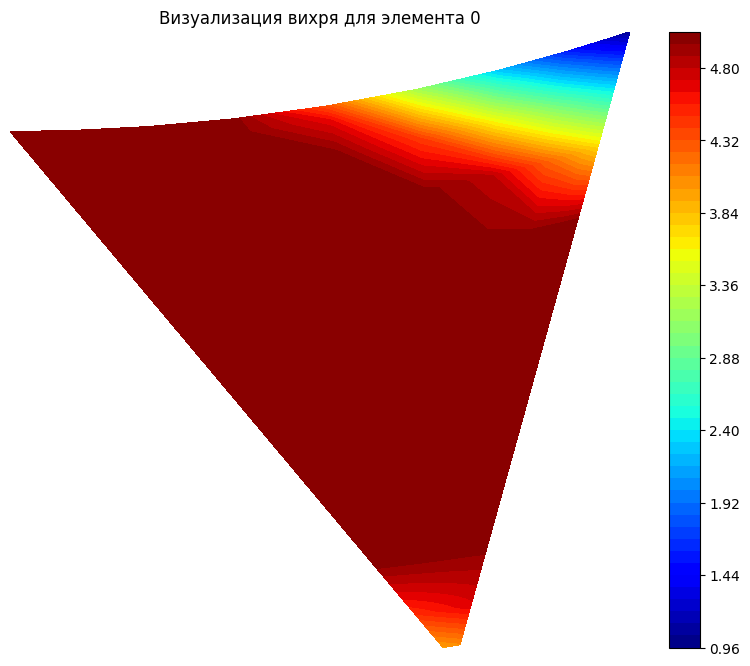

In [4]:
# Функция для построения графиков
def plot_solution(X_star, solution, subplot_index):
    plt.subplot(3, 2, subplot_index)
    plt.scatter(X_star[:, 0], X_star[:, 1], s=1, c=solution, cmap='rainbow', edgecolor='k')
    plt.colorbar()
    plt.title(f'Solution {subplot_index}')

# Предсказание для построения графиковa
lb = X_star.min(0)  # Минимальное значение по каждому признаку
ub = X_star.max(0)  # Максимальное значение по каждому признаку
nn = 200  # Количество точек для построения сетки
x = np.linspace(lb[0], ub[0], nn)  # Линейное пространство по x
y = np.linspace(lb[1], ub[1], nn)  # Линейное пространство по y
X, Y = np.meshgrid(x, y)  # Создание сетки

# Интерполяция предсказанных значений
UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

######################################################################
########################### Шумные данные ###############################
######################################################################
noise = 0.01  # Уровень шума
u_train = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])
v_train = v_train + noise * np.std(v_train) * np.random.randn(v_train.shape[0], v_train.shape[1])

# Обучение модели
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)
model.train(5000)  # Обучение модели на 200000 итераций

# Предполагается, что model.lambda_1 и model.lambda_2 - это тензоры, определенные в вашей модели
lambda_1_value_noisy = model.lambda_1.numpy()  # Получаем значение в виде numpy массива
lambda_2_value_noisy = model.lambda_2.numpy()

# Вычисление ошибки для лямбд
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01) / 0.01 * 100

print('Ошибка лямбда 1: %.5f%%' % (error_lambda_1_noisy))
print('Ошибка лямбда 2: %.5f%%' % (error_lambda_2_noisy))

# Загрузка данных
data_vort = scipy.io.loadmat('cylinder_nektar_t0_vorticity.mat')

x_vort = data_vort['x']
y_vort = data_vort['y']
w_vort = data_vort['w']
modes = data_vort['modes'].item()  # Получаем количество мод
nel = data_vort['nel'].item()  # Получаем количество элементов

# Изменяем размерность данных в соответствии с количеством мод и элементов
xx_vort = np.reshape(x_vort, (modes + 1, modes + 1, nel), order='F')
yy_vort = np.reshape(y_vort, (modes + 1, modes + 1, nel), order='F')
ww_vort = np.reshape(w_vort, (modes + 1, modes + 1, nel), order='F')

# Определение границ области
box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])

# Настройка фигуры
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Пример визуализации данных вихря для первого элемента
element_index = 0  # Индекс элемента для визуализации
x_plot = xx_vort[:, :, element_index]
y_plot = yy_vort[:, :, element_index]
w_plot = ww_vort[:, :, element_index]

# Построение графика
contour = ax.contourf(x_plot, y_plot, w_plot, levels=50, cmap='jet')
plt.colorbar(contour, ax=ax)
ax.set_title('Визуализация вихря для элемента {}'.format(element_index))
plt.show()

C:\Users\77003\AppData\Local\Temp\ipykernel_49228\2760026107.py:11: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1000x800 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(h, cax=cax)


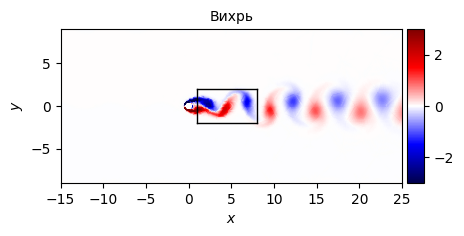

In [5]:
####### Рисунок 0: Вихрь ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06, bottom=1 - 2 / 4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

# Построение графика вихревой скорости
for i in range(nel):
    h = ax.pcolormesh(xx_vort[:, :, i], yy_vort[:, :, i], ww_vort[:, :, i], cmap='seismic', shading='gouraud', vmin=-3, vmax=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Рисуем границы области
ax.plot([box_lb[0], box_lb[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1)
ax.plot([box_ub[0], box_ub[0]], [box_lb[1], box_ub[1]], 'k', linewidth=1)
ax.plot([box_lb[0], box_ub[0]], [box_lb[1], box_lb[1]], 'k', linewidth=1)
ax.plot([box_lb[0], box_ub[0]], [box_ub[1], box_ub[1]], 'k', linewidth=1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Вихрь', fontsize=10)

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

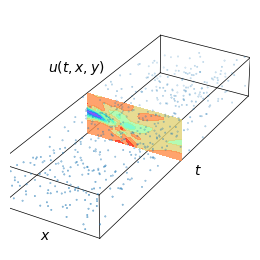

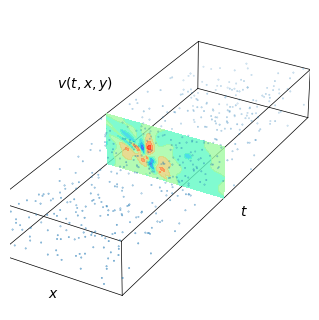

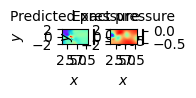

In [6]:
####### Рисунок 1: Обучающие данные ##################
########      u(t,x,y)     ###################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1 - 2 / 4, bottom=0.0, left=0.01, right=0.99, wspace=0)
ax = plt.subplot(gs1[:, 0], projection='3d')
ax.axis('off')

# Настройка границ для 3D графика
r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]
r3 = [y_star.min(), y_star.max()]

# Рисование линий в 3D
for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
    if np.sum(np.abs(s - e)) == r1[1] - r1[0] or np.sum(np.abs(s - e)) == r2[1] - r2[0] or np.sum(np.abs(s - e)) == r3[1] - r3[0]:
        ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

# Рисование обучающих данных
ax.scatter(x_train, t_train, y_train, s=0.1)
ax.contourf(X, UU_star, Y, zdir='y', offset=t_star.mean(), cmap='rainbow', alpha=0.8)

# Добавление аннотаций
ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max() + 1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min() - 1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min() - 3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

def newfig(width, height):
    fig = plt.figure(figsize=(width, height))
    return fig, plt.gca()

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# Настройка графика
fig = plt.figure(figsize=(12, 6))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1 - 2 / 4, bottom=0.0, left=0.01, right=0.99, wspace=0)

########      v(t,x,y)     ###################
ax = plt.subplot(gs1[:, 1], projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
    if np.sum(np.abs(s - e)) == r1[1] - r1[0] or np.sum(np.abs(s - e)) == r2[1] - r2[0] or np.sum(np.abs(s - e)) == r3[1] - r3[0]:
        ax.plot3D(*zip(s, e), color="k", linewidth=0.5)

ax.scatter(x_train, t_train, y_train, s=0.1)
ax.contourf(X, VV_star, Y, zdir='y', offset=t_star.mean(), cmap='rainbow', alpha=0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max() + 1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min() - 1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min() - 3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

# Новый график для давления
fig, ax = newfig(1.015, 0.8)
ax.axis('off')

######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ###########
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1 - 1 / 2, left=0.1, right=0.9, wspace=0.5)

# Predicted pressure
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow',
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize=10)

# Exact pressure
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow',
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize=10)

plt.show()  # Отображение графиков

# 3D

In [20]:
import scipy.io

# Загрузка данных
data = io.loadmat('cylinder_nektar_t0_vorticity.mat')

# Просмотр доступных ключей
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'modes', 'nel', 'w', 'x', 'y'])


Форма modes: (1, 1)
Количество элементов nel: 412
Форма w: (49852,)
Количество уникальных точек по X: 42506
Количество уникальных точек по Y: 41240


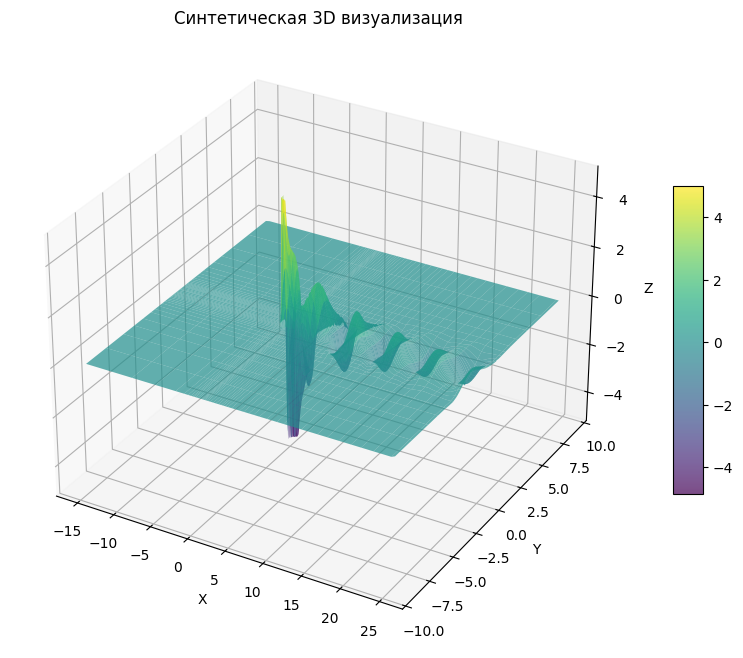

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy.interpolate import griddata

# Шаг 1: Загрузка данных
data = io.loadmat('cylinder_nektar_t0_vorticity.mat')  # Замените на имя вашего файла
modes = data['modes']  # Замените на правильные ключи, если это необходимо
nel = data['nel'][0, 0]  # Количество элементов
w = data['w'].flatten()  # Приведение к одномерному массиву
x = data['x'].flatten()  # Приведение к одномерному массиву
y = data['y'].flatten()  # Приведение к одномерному массиву

# Проверка форм и уникальных точек
print("Форма modes:", modes.shape)
print("Количество элементов nel:", nel)
print("Форма w:", w.shape)
print("Количество уникальных точек по X:", len(np.unique(x)))
print("Количество уникальных точек по Y:", len(np.unique(y)))

# Субдискретизация уникальных координат
x_unique = np.unique(x)[::100]  # Сокращение до каждых 100-й точки
y_unique = np.unique(y)[::100]  # Сокращение до каждых 100-й точки

# Создаем сетку координат для интерполяции
X, Y = np.meshgrid(x_unique, y_unique)

# Интерполяция для значения Z
# Используем значения w для создания Z
Z = griddata((x, y), w, (X, Y), method='linear')

# Визуализация
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Создаем поверхность
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)

# Настройки графика
ax.set_title('Синтетическая 3D визуализация')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Добавляем цветовую шкалу
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


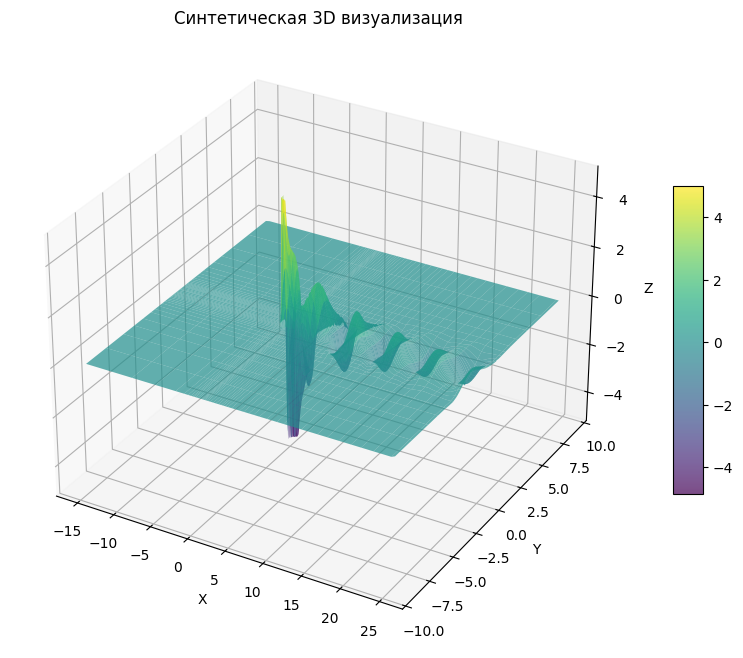

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy.interpolate import griddata
from scipy.io import savemat

# Шаг 1: Загрузка данных
modes = data['modes']
nel = data['nel'][0, 0]
w = data['w'].flatten()
x = data['x'].flatten()
y = data['y'].flatten()

# Субдискретизация уникальных координат
x_unique = np.unique(x)[::100]  # Сокращение до каждых 100-й точки
y_unique = np.unique(y)[::100]  # Сокращение до каждых 100-й точки

# Создаем сетку координат для интерполяции
X, Y = np.meshgrid(x_unique, y_unique)

# Интерполяция для значения Z
Z = griddata((x, y), w, (X, Y), method='linear')

# Визуализация
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)
ax.set_title('Синтетическая 3D визуализация')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

# Сохранение данных в .npy файлы
np.save('synthetic_X.npy', X)
np.save('synthetic_Y.npy', Y)
np.save('synthetic_Z.npy', Z)

# Сохранение в .mat файл
data_to_save = {
    'X': X,
    'Y': Y,
    'Z': Z
}
savemat('synthetic_data.mat', data_to_save)

In [1]:
class PhysicsInformedNNNavierStocks3D:
    def __init__(self, x, y, z, t, u, v, w, layers):
        # Объединяем входные данные x, y, z и t в одном массиве
        X = np.concatenate([x, y, z, t], 1)

        # Установка нижних и верхних границ области на основе входных данных
        self.lb = X.min(0)  # Нижняя граница
        self.ub = X.max(0)  # Верхняя граница

        self.X = X  # Сохраняем объединенные входные данные

        self.x = X[:, 0:1]  # Извлекаем координату x
        self.y = X[:, 1:2]  # Извлекаем координату y
        self.z = X[:, 2:3]  # Извлекаем координату z
        self.t = X[:, 3:4]  # Извлекаем временную координату t

        self.u = u  # Сохраняем значение u (например, скорость по x)
        self.v = v  # Сохраняем значение v (например, скорость по y)
        self.w = w  # Сохраняем значение w (например, скорость по z)

        # Определяем структуру нейронной сети
        self.layers = layers

        # Инициализируем веса и смещения
        self.weights, self.biases = self.initialize_NN(layers)

        # Инициализация параметров для физических уравнений
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)  # Переменная lambda_1
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)  # Переменная lambda_2

        # Преобразование входных данных в тензоры для TensorFlow
        self.x_tf = tf.convert_to_tensor(np.reshape(x, (-1, 1)), dtype=tf.float32)
        self.y_tf = tf.convert_to_tensor(np.reshape(y, (-1, 1)), dtype=tf.float32)
        self.z_tf = tf.convert_to_tensor(np.reshape(z, (-1, 1)), dtype=tf.float32)  # Новая координата z
        self.t_tf = tf.convert_to_tensor(np.reshape(t, (-1, 1)), dtype=tf.float32)  # Временные границы

        self.u_tf = tf.convert_to_tensor(np.reshape(u, (-1, 1)), dtype=tf.float32)  # Преобразуем u в тензор
        self.v_tf = tf.convert_to_tensor(np.reshape(v, (-1, 1)), dtype=tf.float32)  # Преобразуем v в тензор
        self.w_tf = tf.convert_to_tensor(np.reshape(w, (-1, 1)), dtype=tf.float32)  # Преобразуем w в тензор

        # Получаем начальные предсказания с помощью нейронной сети
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_w_pred = self.net_NS(self.x_tf, self.y_tf, self.z_tf, self.t_tf)

        # Определение оптимизатора
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(num_layers - 1):
            W = tf.Variable(tf.random.normal([layers[l], layers[l + 1]], stddev=0.1), dtype=tf.float32)
            b = tf.Variable(tf.zeros([1, layers[l + 1]]), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
        return weights, biases

    def neural_net(self, X, weights, biases):
        # Прямой проход через нейронную сеть
        H = X
        for l in range(len(weights)):
            H = tf.tensordot(H, weights[l], axes=1) + biases[l]
            if l < len(weights) - 1:
                H = tf.nn.tanh(H)  # Используем активационную функцию tanh
        return H

    def net_NS(self, x, y, z, t):
        # Расчет уравнений Навье-Стокса
        lambda_1 = self.lambda_1  # Получаем значение lambda_1
        lambda_2 = self.lambda_2  # Получаем значение lambda_2

        # Используем GradientTape для вычисления производных
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, y, z, t])  # Отслеживаем x, y, z, t для производных
            psi_and_p = self.neural_net(tf.concat([x, y, z, t], 1), self.weights, self.biases)  # Получаем предсказания
            psi = psi_and_p[:, 0:1]  # Извлекаем psi
            p = psi_and_p[:, 1:2]  # Извлекаем p

            # Вычисление градиентов
            u = tape.gradient(psi, y)  # Градиент psi по y
            v = -tape.gradient(psi, x)  # Отрицательный градиент psi по x
            w = tape.gradient(psi, z)  # Градиент psi по z

            u_t = tape.gradient(u, t)  # Градиент u по t
            u_x = tape.gradient(u, x)  # Градиент u по x
            u_y = tape.gradient(u, y)  # Градиент u по y
            u_z = tape.gradient(u, z)  # Градиент u по z
            u_xx = tape.gradient(u_x, x)  # Второй градиент u по x
            u_yy = tape.gradient(u_y, y)  # Второй градиент u по y
            u_zz = tape.gradient(u_z, z)  # Второй градиент u по z

            v_t = tape.gradient(v, t)  # Градиент v по t
            v_x = tape.gradient(v, x)  # Градиент v по x
            v_y = tape.gradient(v, y)  # Градиент v по y
            v_z = tape.gradient(v, z)  # Градиент v по z
            v_xx = tape.gradient(v_x, x)  # Второй градиент v по x
            v_yy = tape.gradient(v_y, y)  # Второй градиент v по y
            v_zz = tape.gradient(v_z, z)  # Второй градиент v по z

            w_t = tape.gradient(w, t)  # Градиент w по t
            w_x = tape.gradient(w, x)  # Градиент w по x
            w_y = tape.gradient(w, y)  # Градиент w по y
            w_z = tape.gradient(w, z)  # Градиент w по z
            w_xx = tape.gradient(w_x, x)  # Второй градиент w по x
            w_yy = tape.gradient(w_y, y)  # Второй градиент w по y
            w_zz = tape.gradient(w_z, z)  # Второй градиент w по z

            p_x = tape.gradient(p, x)  # Градиент p по x
            p_y = tape.gradient(p, y)  # Градиент p по y
            p_z = tape.gradient(p, z)  # Градиент p по z

        # Освобождение ресурсов GradientTape
        del tape

        # Вычисление функций f_u, f_v и f_w для уравнений Навье-Стокса
        f_u = u_t + lambda_1 * (u * u_x + v * u_y + w * u_z) + p_x - lambda_2 * (u_xx + u_yy + u_zz)  # Уравнение для u
        f_v = v_t + lambda_1 * (u * v_x + v * v_y + w * v_z) + p_y - lambda_2 * (v_xx + v_yy + v_zz)  # Уравнение для v
        f_w = w_t + lambda_1 * (u * w_x + v * w_y + w * w_z) + p_z - lambda_2 * (w_xx + w_yy + w_zz)  # Уравнение для w

        return u, v, w, p, f_u, f_v, f_w  # Возвращаем u, v, w, p и функции f_u, f_v, f_w

    def forward(self, x, y, z, t):
        # Forward pass (ensure it's differentiable)
        X = tf.concat([x, y, z, t], 1)
        return self.neural_net(X, self.weights, self.biases)

    def loss(self):
        # Вычисление потерь
        # Здесь вы можете определить свою функцию потерь на основе предсказаний и реальных значений
        # Например, можете использовать MSE для предсказания скоростей и давления
        # а также для f_u, f_v, f_w
        # Параметры могут быть определены в зависимости от задач

        # Обратите внимание: это всего лишь пример. Реальная реализация может отличаться
        u_pred, v_pred, w_pred, p_pred, f_u_pred, f_v_pred, f_w_pred = self.net_NS(self.x_tf, self.y_tf, self.z_tf, self.t_tf)

        loss_u = tf.reduce_mean(tf.square(f_u_pred))  # Ошибка для u
        loss_v = tf.reduce_mean(tf.square(f_v_pred))  # Ошибка для v
        loss_w = tf.reduce_mean(tf.square(f_w_pred))  # Ошибка для w

        return loss_u + loss_v + loss_w  # Общая потеря

    def train(self, nIter):
        # Процесс обучения
        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss_value = self.loss()  # Вычисляем потерю

            # Вычисляем градиенты
            grads = tape.gradient(loss_value, self.weights + self.biases + [self.lambda_1, self.lambda_2])

            # Обновляем параметры
            self.optimizer.apply_gradients(zip(grads, self.weights + self.biases + [self.lambda_1, self.lambda_2]))

            if it % 100 == 0:  # Выводим информацию каждые 100 итераций
                print(f"Iteration {it}: Loss = {loss_value.numpy()}")


In [9]:
# Define the number of training samples
N_train = 100

# Define the neural network structure
layers = [4, 20, 20, 20, 20, 20, 20, 20, 20, 3]  # Updated input and output dimensions

# Synthetic Data Generation
def generate_synthetic_data(N, T):
    # Generate synthetic spatial coordinates (x, y, z)
    x = np.random.rand(N, 1)
    y = np.random.rand(N, 1)
    z = np.random.rand(N, 1)

    # Generate time steps
    t = np.linspace(0, 1, T).reshape(-1, 1)

    # Create a grid of spatial and temporal data
    XX, YY, ZZ, TT = np.meshgrid(x, y, z, t, indexing='ij')
    x_star = XX.flatten()[:, None]
    y_star = YY.flatten()[:, None]
    z_star = ZZ.flatten()[:, None]
    t_star = TT.flatten()[:, None]

    # Generate synthetic velocity and pressure fields
    U = np.sin(np.pi * x_star) * np.cos(np.pi * y_star) * np.sin(np.pi * z_star) * np.sin(np.pi * t_star)
    V = -np.cos(np.pi * x_star) * np.sin(np.pi * y_star) * np.sin(np.pi * z_star) * np.sin(np.pi * t_star)
    W = np.sin(np.pi * x_star) * np.sin(np.pi * y_star) * np.cos(np.pi * z_star) * np.sin(np.pi * t_star)
    P = (x_star ** 2 + y_star ** 2 + z_star ** 2) * (1 - t_star)

    return x_star, y_star, z_star, t_star, U, V, W, P

# Generate synthetic data
N = 100  # Number of spatial points
T = 50   # Number of time points
x_star, y_star, z_star, t_star, U_star, V_star, W_star, P_star = generate_synthetic_data(N, T)

# Rearranging Data as per the original structure
x = x_star.flatten()[:, None]  # NT x 1
y = y_star.flatten()[:, None]  # NT x 1
z = z_star.flatten()[:, None]  # NT x 1
t = t_star.flatten()[:, None]  # NT x 1
u = U_star.flatten()[:, None]  # NT x 1
v = V_star.flatten()[:, None]  # NT x 1
w = W_star.flatten()[:, None]  # NT x 1
p = P_star.flatten()[:, None]  # NT x 1

######################################################################
######################## Noiseless Data #############################
######################################################################
# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
z_train = z[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]
w_train = w[idx, :]

# Initialize the PhysicsInformedNNNavierStocks3D model
model = PhysicsInformedNNNavierStocks3D(x_train, y_train, z_train, t_train, u_train, v_train, w_train, layers)

# Training
model.train(100)
# Test Data
snap = 10  # Ensure this index is less than T
if snap < T:
    u_star = U_star[:, snap].flatten()[:, None]
    v_star = V_star[:, snap].flatten()[:, None]
    w_star = W_star[:, snap].flatten()[:, None]
    p_star = P_star[:, snap].flatten()[:, None]
else:
    raise ValueError(f"Snapshot index {snap} is out of bounds for T = {T}.")

# Prediction
u_pred, v_pred, w_pred, p_pred = model.predict(x_star, y_star, z_star, t_star)

# Retrieve lambda_1 and lambda_2 values if they are attributes of the model
lambda_1_value = model.lambda_1.numpy()
lambda_2_value = model.lambda_2.numpy()

# Error Calculation
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_w = np.linalg.norm(w_star - w_pred, 2) / np.linalg.norm(w_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - 0.01) / 0.01 * 100

print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error w: %e' % (error_w))
print('Error p: %e' % (error_p))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

KeyboardInterrupt: 

In [ ]:
# Функция для построения графиков для трехмерного пространства
def plot_solution_3d(X_star, solution, subplot_index, title):
    ax = plt.subplot(2, 2, subplot_index, projection='3d')
    ax.scatter(X_star[:, 0], X_star[:, 1], X_star[:, 2], s=1, c=solution, cmap='rainbow', edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Предсказание для построения графиков
lb = np.array([x_star.min(), y_star.min(), z_star.min()])  # Минимальное значение по каждому признаку
ub = np.array([x_star.max(), y_star.max(), z_star.max()])  # Максимальное значение по каждому признаку
nn = 20  # Количество точек для построения сетки
x = np.linspace(lb[0], ub[0], nn)  # Линейное пространство по x
y = np.linspace(lb[1], ub[1], nn)  # Линейное пространство по y
z = np.linspace(lb[2], ub[2], nn)  # Линейное пространство по z
X, Y, Z = np.meshgrid(x, y, z)  # Создание сетки

# Интерполяция предсказанных значений
UU_star = griddata(x_star, u_pred.flatten(), (X, Y, Z), method='cubic')
VV_star = griddata(y_star, v_pred.flatten(), (X, Y, Z), method='cubic')
WW_star = griddata(z_star, w_pred.flatten(), (X, Y, Z), method='cubic')
PP_star = griddata(p_star.flatten(), (X, Y, Z), method='cubic')

# Визуализация результатов
plt.figure(figsize=(15, 10))

# График U
plot_solution_3d(np.hstack((x_star, y_star, z_star)), u_pred.flatten(), 1, 'Velocity U')

# График V
plot_solution_3d(np.hstack((x_star, y_star, z_star)), v_pred.flatten(), 2, 'Velocity V')

# График W
plot_solution_3d(np.hstack((x_star, y_star, z_star)), w_pred.flatten(), 3, 'Velocity W')

# График давления P
plot_solution_3d(np.hstack((x_star, y_star, z_star)), p_pred.flatten(), 4, 'Pressure P')

plt.tight_layout()
plt.show()

# Настройка фигуры для визуализации данных вихря в 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Выбор индекса элемента для визуализации
element_index = 0  # Индекс элемента для визуализации
x_plot = xx_vort[:, :, element_index]
y_plot = yy_vort[:, :, element_index]
w_plot = ww_vort[:, :, element_index]

# Построение графика вихря
contour = ax.contourf(x_plot, y_plot, w_plot, levels=50, cmap='jet')
plt.colorbar(contour, ax=ax)
ax.set_title('Визуализация вихря для элемента {}'.format(element_index))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('W')

plt.show()